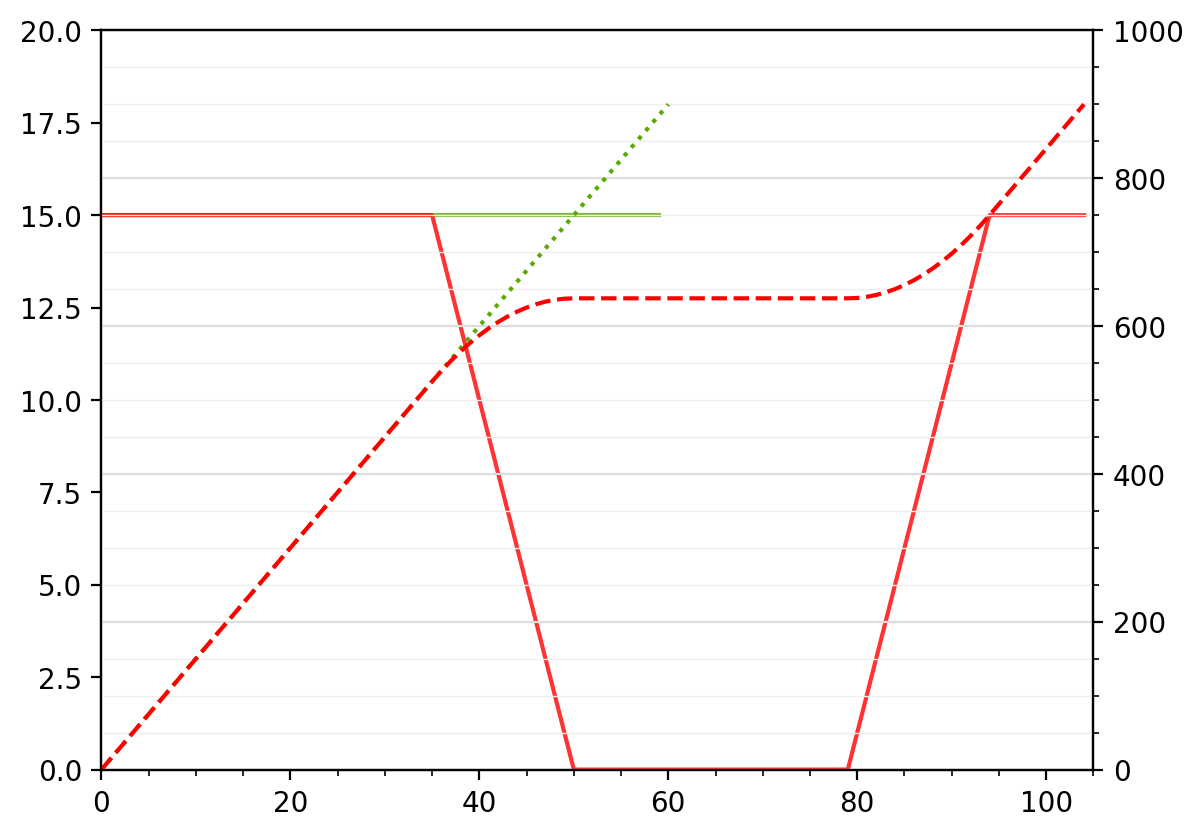

In [1]:
%config InlineBackend.figure_format = 'retina'
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt


def nice_grid(plot):
    plot.rc("axes", axisbelow=True)
    plot.grid(True, which="major", color="#DDD")
    plot.grid(True, which="minor", color="#EEE", linewidth=0.5)
    plot.minorticks_on()


# constants
G = 9.81  # m/s^2
R_air = 8314.5 / 28.96  # gas constant for air (in J/kg*K)
energydensity_fuel = 34.2  # gasoline energy density (in MJ/l)

# ambient air conditions
ambient = dict(
    v_air=0,  # ambient wind velocity where negative is headwind  (in m/s)
    temp=25 + 273.15,  # ambient air temperature (in K)
    pressure=100000,  # ambient air pressure (in Pa)
)
ambient["rho"] = ambient["pressure"] / (
    R_air * ambient["temp"]
)  # ambient air density (in kg/m^3)


decel = [15 - t * 15 / 15 for t in range(0, 15)]
accel = [t for t in range(1, 16)]
cycle = dict(
    time=[range(0, 60), range(0, 105)],
    mps=[
        [15] * 60,
        [*([15] * 35), *decel, *([0] * 30), *accel, *([15] * 10)],
    ],
    name="constant velocity",
)


vehicle = dict(
    mass=2000,  # vehicle mass [kg]
    C_drag=0.3,  # drag coefficient [-]
    A_front=2.0,  # frontal area for drag [m^2]
    C_roll_0=0.01,  # tire rolling resistance coefficient [-]
    p_tire=3.0,
    Wdot_access=280,  # average accessory loads [W]
    eta_elec=0.70,  # efficiency of alternator or electrical system for accessories [-]
    eta_a=0.22,  # constant for powertrain efficency   eta_tr = eta_a*
    eta_Wdot1=1e6,  # reference power to account for efficiency variation with load [W]
    eta_Wdot2=1e-6,  # reference power to account for efficiency variation with load [W]
)

integral_1 = [0, *np.cumsum(cycle["mps"][0])]
integral_2 = [np.trapz(cycle["mps"][1][0:t]) for t in range(1, 106)]

fig, ax1 = plt.subplots()
ax1.set_xlim(0, 105)
ax2 = ax1.twinx()

ax1.plot(cycle["mps"][0], color="xkcd:leaf green", alpha=0.8)
ax1.plot(cycle["mps"][1], color="red", alpha=0.8)
ax2.plot(integral_1, linestyle="dotted", color="xkcd:leaf green")
ax2.plot(integral_2, linestyle="dashed", color="red")
ax1.set_ylim(0, 20)
ax2.set_ylim(0, 1000)
nice_grid(plt)

In [2]:

# Function to solve system of 1st-order linear ODEs with oscillatory forcing
def dydt_vehicle(t, y, cycle, vehicle, amb, index, idx):
    # Determine instantaneous values of velocity, acceleration, and road angle.
    dydt = [0] * len(y)

    v_veh = np.interp(t, cycle["time"][idx], cycle["v_veh"])
    dv_vehdt = np.interp(t, cycle["time"][idx], cycle["dv_vehdt"])
    alpha = np.pi / 180 * np.interp(t, cycle["time"][idx], cycle["alpha"])

    # Set instantaneous velocity
    dydt[index["x"]] = v_veh

    # Determine instantaneous vehicle load (power demand for engine)
    if v_veh > 0:
        C_roll = vehicle["C_roll_0"] + 1 / vehicle["p_tire"] * (
            0.01 + 9.5e-7 * v_veh**2
        )
        Wdot_veh = (
            vehicle["mass"]
            * (max(0, dv_vehdt + G * np.sin(alpha)) + C_roll * G * np.cos(alpha))
            + vehicle["C_drag"]
            * vehicle["A_front"]
            * 0.5
            * amb["rho"]
            * (v_veh - amb["v_air"]) ** 2
        ) * v_veh + vehicle["Wdot_access"] / vehicle["eta_elec"]
    else:
        Wdot_veh = vehicle["Wdot_access"] / vehicle["eta_elec"]

    dydt[index["E_veh"]] = Wdot_veh

    # Determine power train efficiency and instantaneous fuel energy demand rate
    eta = vehicle["eta_a"] * (
        np.exp(-Wdot_veh / vehicle["eta_Wdot1"])
        - np.exp(-Wdot_veh / vehicle["eta_Wdot2"])
    )
    print(eta)
    dydt[index["E_fuel"]] = Wdot_veh / eta
    return dydt


# Set up indices and intial conditions for solution vector y(t) = [x; Wdot_veh]'
index = dict(x=0, E_veh=1, E_fuel=2)
y_0 = [None] * 3
y_0[index["x"]] = 0
y_0[index["E_veh"]] = 0
y_0[index["E_fuel"]] = 0

for idx, speed in enumerate(cycle["mps"]):
    arr_length = len(speed)
    time = cycle["time"][idx]

    #  driving cycle vehicle velocities [m/s]
    cycle["v_veh"] = speed
    # road angle to horizontal  [deg.]
    cycle["alpha"] = [0] * arr_length
    # Calculate vehicle acceleration and identify times when acceleration is positive
    cycle["dv_vehdt"] = np.gradient(cycle["v_veh"])

    # Call an ODE integrator to solve for y(t)
    sol = solve_ivp(
        dydt_vehicle,
        [0, time[-1] + 1],
        y_0,
        "RK45",
        args=(cycle, vehicle, ambient, index, idx),
        rtol=1e-4,
        atol=1e-4,
    )

    vehicle["x"] = sol.y[index["x"]] / 1000
    vehicle["E_veh"] = sol.y[index["E_veh"]] / 1000
    vehicle["E_fuel"] = sol.y[index["E_fuel"]] / 1000

    vehicle["kJperkm"] = (
        vehicle["kJperkm"] if "kJperkm" in vehicle else [0] * len(cycle["mps"][idx])
    )
    vehicle["kmperliter"] = (
        vehicle["kmperliter"]
        if "kmperliter" in vehicle
        else [0] * len(cycle["mps"][idx])
    )
    vehicle["mpg"] = (
        vehicle["mpg"] if "mpg" in vehicle else [0] * len(cycle["mps"][idx])
    )

    vehicle["kJperkm"][idx] = (
        vehicle["E_fuel"][-1] / vehicle["x"][-1]
    )  # MJ of fuel energy demand per km
    vehicle["kmperliter"][idx] = (
        1000 * vehicle["x"][-1] / (vehicle["E_fuel"][-1] / energydensity_fuel)
    )
    vehicle["mpg"][idx] = 2.35215 * vehicle["kmperliter"][idx]

    #  Allocate memory for vectors for calculating vehicle power requirements
    vehicle["Wdot_drag"] = np.zeros(arr_length)
    vehicle["Wdot_roll"] = np.zeros(arr_length)
    vehicle["Wdot_accel"] = np.zeros(arr_length)

    # Calculate instanaeous power (in kW) to overcome forces on vehicle
    #   and integrate to get total work required (in kWh)
    vehicle["Wdot_drag"] = (
        (
            np.array(
                vehicle["C_drag"]
                * vehicle["A_front"]
                * 0.5
                * ambient["rho"]
                * (np.array(cycle["v_veh"]) - ambient["v_air"]) ** 2
            )
        )
        * cycle["v_veh"]
        / 1000
    )

    C_roll = vehicle["C_roll_0"] + (
        1 / vehicle["p_tire"] * (0.01 + 9.5e-7 * np.array(cycle["v_veh"]) ** 2)
    )
    vehicle["Wdot_roll"] = (
        vehicle["mass"] * C_roll * (G * np.cos(cycle["alpha"]) * cycle["v_veh"] / 1000)
    )
    vehicle["Wdot_accel"] = (
        np.maximum(0, vehicle["mass"] * cycle["dv_vehdt"]) * cycle["v_veh"] / 1000
    )
    vehicle["Wdot_access_vec"] = (
        np.ones(len(speed)) * vehicle["Wdot_access"] / vehicle["eta_elec"] / 1000
    )
    vehicle["Wdot"] = (
        vehicle["Wdot_drag"]
        + vehicle["Wdot_roll"]
        + vehicle["Wdot_accel"]
        + vehicle["Wdot_access_vec"]
    )
    # Set up a trapezoidal integration to solve the average values for the cycle
    for key in [
        "Wdot_drag",
        "Wdot_roll",
        "Wdot_accel",
        "Wdot_access_vec",
        "Wdot",
    ]:
        key_avg = f"{key}_avg"
        vehicle[key_avg] = (
            vehicle[key_avg] if key_avg in vehicle else np.ones(len(cycle["mps"]))
        )

        vehicle[key_avg][idx] = (
            np.trapz(vehicle[key], cycle["time"][idx]) / cycle["time"][idx][-1]
        )
        print(key_avg, vehicle[key_avg][idx])

Wdot_drag_avg 1.1828308364628362
Wdot_roll_avg 3.9449688750000007
Wdot_accel_avg 0.0
Wdot_access_vec_avg 0.3999999999999999
Wdot_avg 5.527799711462837
Wdot_drag_avg 0.5974812173927659
Wdot_roll_avg 2.2744381240384617
Wdot_accel_avg 2.1634615384615383
Wdot_access_vec_avg 0.4
Wdot_avg 5.435380879892766


Text(0.5, 1.0, 'Average Vehicle Loads for constant velocity')

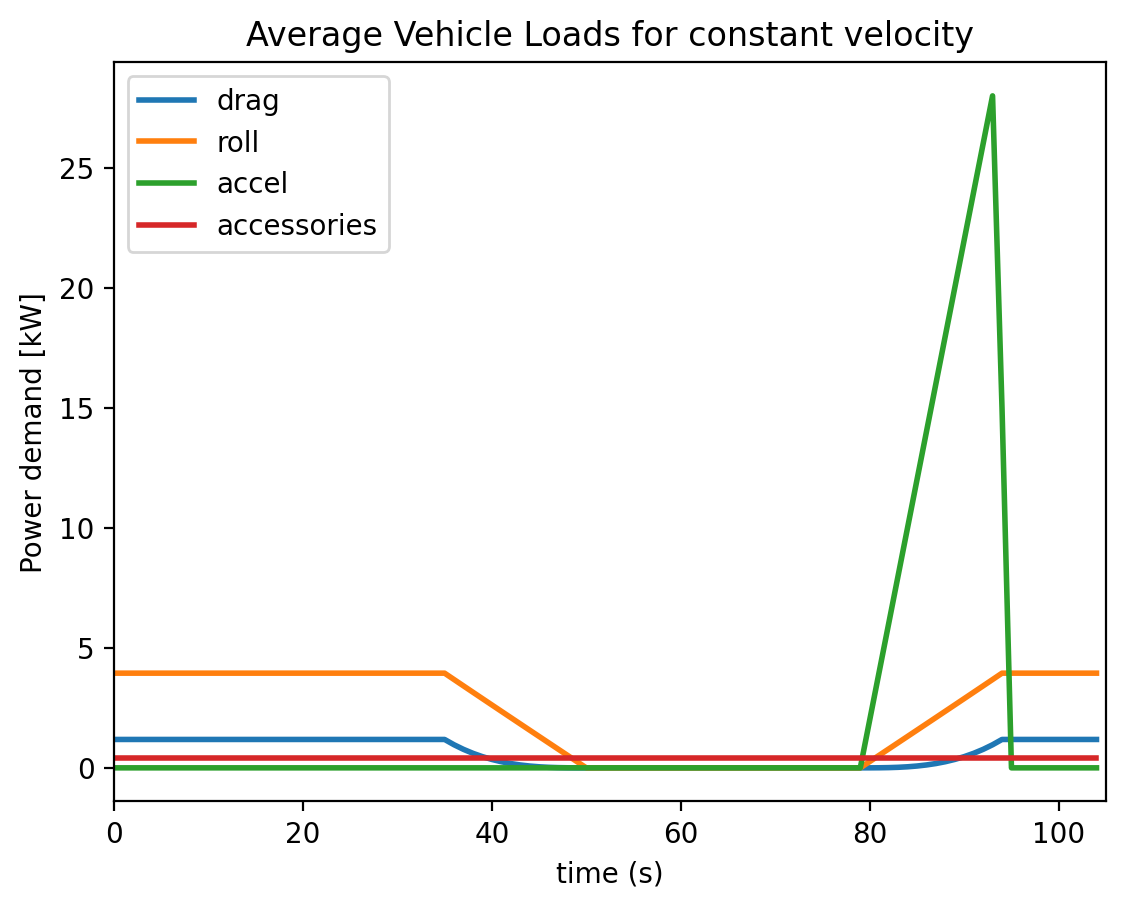

In [3]:
# Plot instantaneous power required for each load for the last cycle
plt.plot(cycle["time"][1], vehicle["Wdot_drag"], label="drag", linewidth=2)
plt.plot(cycle["time"][1], vehicle["Wdot_roll"], label="roll", linewidth=2)
plt.plot(cycle["time"][1], vehicle["Wdot_accel"], label="accel", linewidth=2)
plt.plot(cycle["time"][1], vehicle["Wdot_access_vec"], label="accessories", linewidth=2)
plt.xlabel("time (s)")
plt.ylabel("Power demand [kW]")
# plt.ylim([0, 400])
plt.xlim(0, 105)
plt.legend()
plt.title(f'Average Vehicle Loads for {cycle["name"]}')

average power demands [5.52779971 5.43538088]
[20.304254769980705, 11.924543083224764]


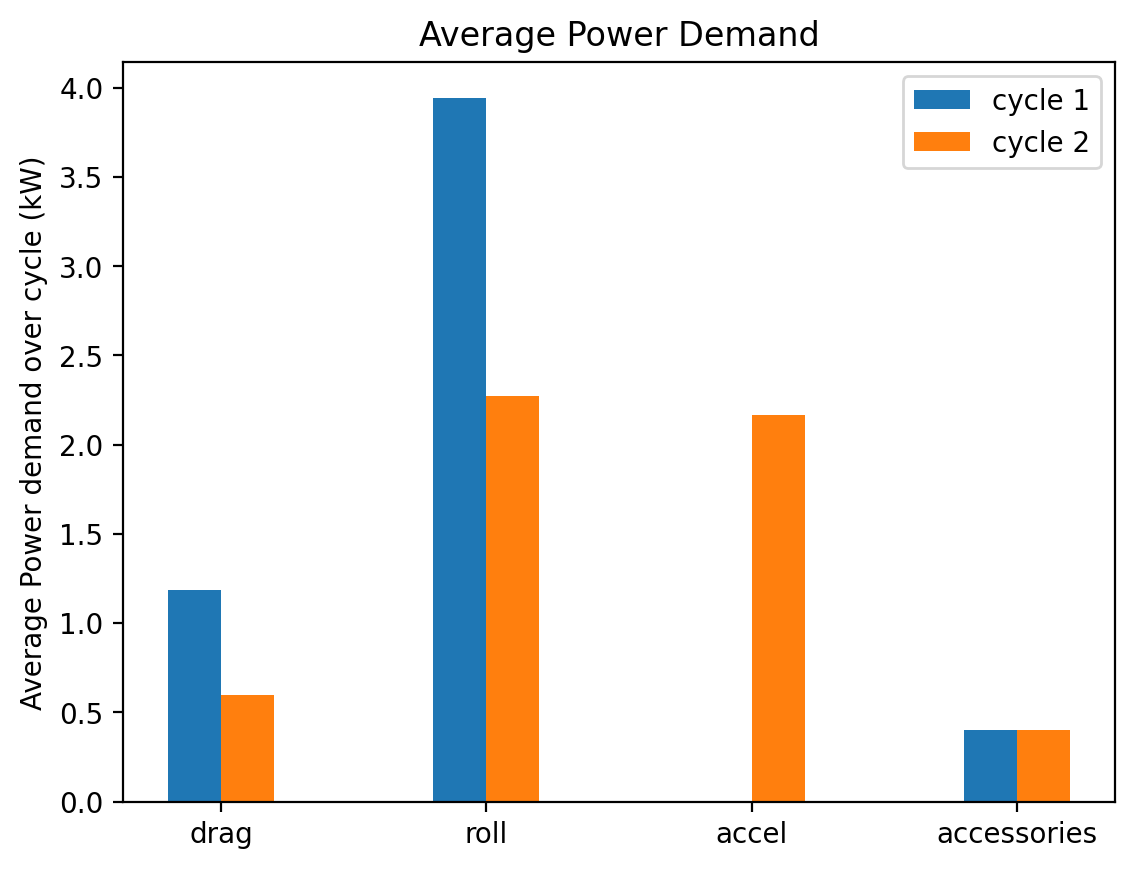

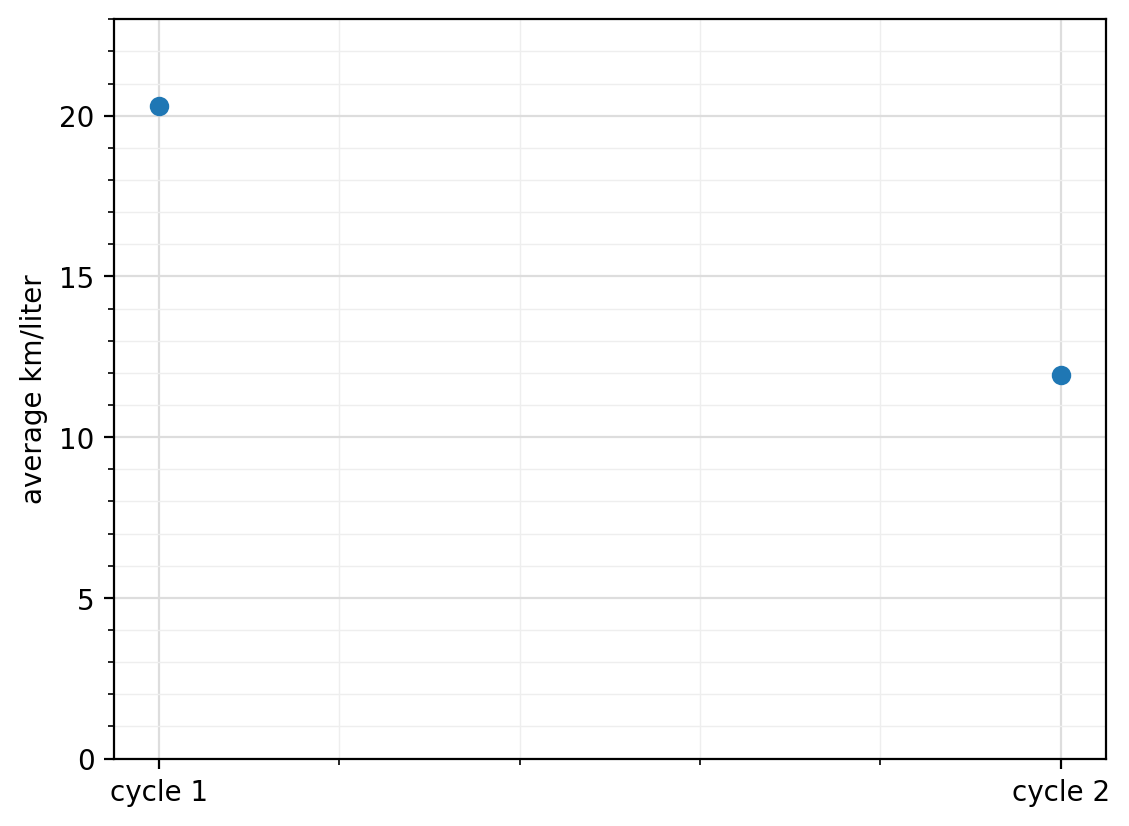

In [4]:
# Plot average power demand for each force or load
categories = ["drag", "roll", "accel", "accessories"]
num_categories = len(categories)
num_values = len(vehicle["Wdot_drag_avg"])  # Assuming all lists have the same length

# Setting up the bar width and positions
bar_width = 0.2
# Create an array for the positions of groups
index = np.arange(num_categories)

fig, ax = plt.subplots()

labels = [""]
for i in range(num_values):
    # Creating the bars for each category
    ax.bar(
        index - bar_width / 2 + i * bar_width,
        [
            vehicle["Wdot_drag_avg"][i],
            vehicle["Wdot_roll_avg"][i],
            vehicle["Wdot_accel_avg"][i],
            vehicle["Wdot_access_vec_avg"][i],
        ],
        bar_width,
        label=f"cycle {i + 1}",
    )

# Additional chart settings
ax.set_ylabel("Average Power demand wover cycle (kW)")
ax.set_title(f"Average Power Demand")
ax.set_xticks(index)
ax.set_xticklabels(categories)
ax.legend()

print("average power demands", vehicle["Wdot_avg"])
plt.figure()
plt.scatter(["cycle 1", "cycle 2"], vehicle["kmperliter"][0:2])
print(vehicle["kmperliter"][0:2])
plt.ylim(0, 23)
plt.ylabel("average km/liter")
nice_grid(plt)

In [5]:
# Plot averge fuel economy for vehicle
plt.plot(cycle["kph"], vehicle["kmperliter"], linewidth=2)
plt.xlabel("Vehicle speed [kph]")
plt.ylabel("km/liter")
plt.title(f'Average Fuel Economy for {cycle["name"]}')
plt.xlim(60, 120)

KeyError: 'kph'